<h1 id='Part1'>A Look at the relevant data</h1>

In order to get a better understanding of the data we will be take a closer look in the first section, highlighting features and main take aways.

First, let's read in the data and necessary libraries.

Key questions that we would like to answer:

What is the AirBnb market in Seattle looking like? 
 



In [1]:
# import all the packages
import numpy as np
import pandas as pd
from pandas.plotting import table
import matplotlib.pyplot as plt
import seaborn as sns
import string as str
from adjustText import adjust_text
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
%matplotlib inline
import DataPrepFunctions as dtprep
from mpl_toolkits.basemap import Basemap
from pyproj import Proj, transform
sia = SentimentIntensityAnalyzer()
df = pd.read_csv('./listings.csv')

# look into the dimensions of the DB
num_rows = df.shape[0] 
num_cols = df.shape[1]

# utils
# function to convert string into float
dollar_to_float= lambda x: x.replace('[\$,]', '', regex=True).astype(float)

# look into the type of data available 
df.dtypes.value_counts()

# display the first 5 rows
df.head(5)



,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,10.0,f,NaN,WASHINGTON,f,strict,t,t,6,1.48
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,10.0,f,NaN,WASHINGTON,f,strict,f,f,2,1.15
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,9.0,f,NaN,WASHINGTON,f,strict,f,f,1,0.89


<h3 id='Part1.1'> Property type </h3>

Taking a dive into the most common properties in the market and the most relevant features

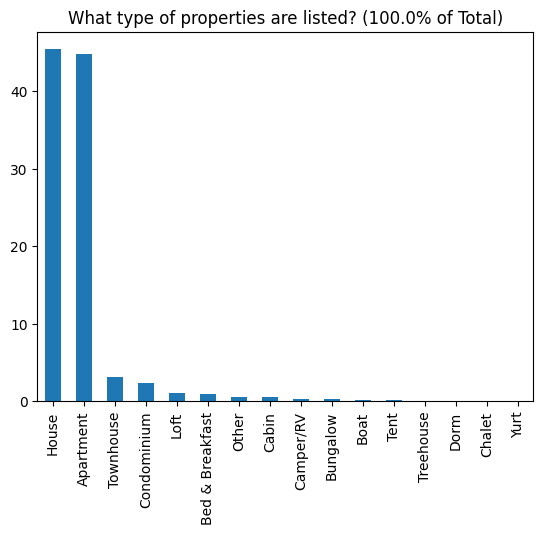

In [2]:
# Selection the columns relevant for our analysis 
prop_columns = ['property_type',"room_type","bed_type","amenities","accommodates","bathrooms","bedrooms","beds"]
df_properties = df[prop_columns]

df_properties.head(5)
# selection the top 5 properties 
df_chart = df_properties['property_type'].value_counts(normalize = True)*100
df_chart
sampleSize= np.sum(df_chart)

# plotting the type of properties
df_chart.plot(kind = "bar");
plt.title(f'What type of properties are listed? ({sampleSize}% of Total)');
plt.savefig('TypeOfProp.png',bbox_inches='tight',dpi=100)   


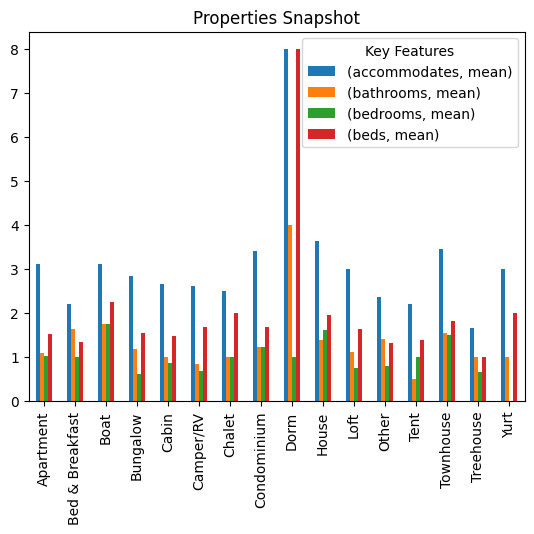

In [3]:
# Looking into the standard features of each property type
group_prop= df_properties.groupby("property_type",group_keys=True ,as_index=False)

#plot the key features of the properties
group_prop[["accommodates","bathrooms","bedrooms","beds"]].agg(["mean"]).plot(kind = "bar")
#print(group_prop[["accommodates","bathrooms","bedrooms","beds"]].agg(["count"]))
plt.title("Properties Snapshot");
plt.xlabel(xlabel="", fontdict=None)
plt.legend(title="Key Features")
plt.savefig('PropSnap.png',bbox_inches='tight',dpi=100)   

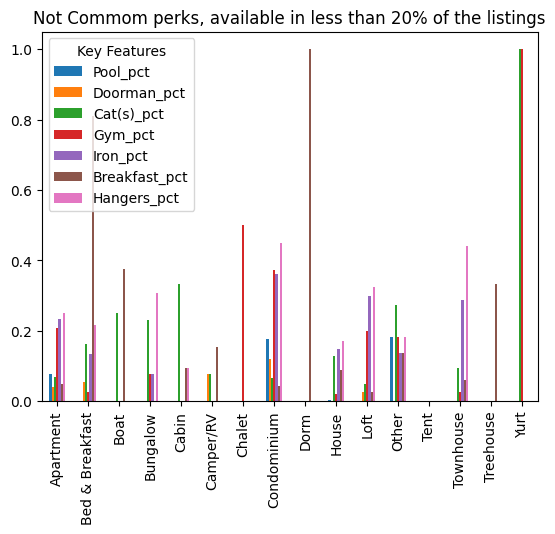

In [4]:
# What type of amenities are usually availabel witht the property
amenitis_list = []
# create the full list of available amenities and compute the percentage available for each type of properties
amenitis_list = dtprep.convert_colCont2List(df_properties,'amenities')
#drop essentials being 
df_comm = (dtprep.mostcommon_stuff(group_prop,df_properties,amenitis_list)).drop("Essentials_pct",axis=1)

#plot the most common amenities
reduce_df_comm = df_comm.iloc[:, np.where(((df_comm.mean() < 0.2) & (df_comm.mean() > 0.01)) == True)[0]]
#np.where(((df_comm.mean() < 0.2) & (df_comm.mean() > 0.01))
#np.where((df_comm.mean() > 0.5)
reduce_df_comm.plot(kind = "bar")
plt.title("Not Commom perks, available in less than 20% of the listings");
plt.legend(title="Key Features")
plt.savefig('PropPerks_NotCommon.png',bbox_inches='tight',dpi=100) 

<h3 id='Part1.2'> Location  </h3>

Looking into how the supply of properties is spread and what are the classic neighbours where to find the perfect airbnb 

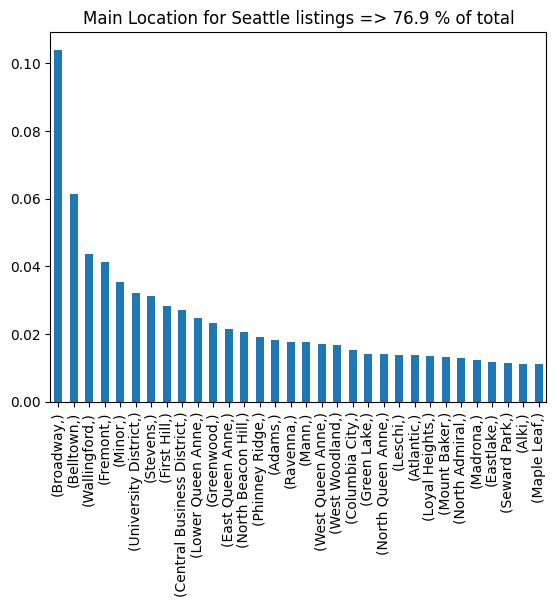

In [5]:
# granular location where the listings are located
loc_cols = ['neighbourhood_cleansed']
tot = (df
[loc_cols]
.value_counts()/df.shape[0])[(df
[loc_cols]
.value_counts()/df.shape[0])>0.01].sum()

# plot the key locations
(df
[loc_cols]
.value_counts()/df.shape[0])[(df
[loc_cols]
.value_counts()/df.shape[0])>0.01].plot(kind="bar")

plt.title(f'Main Location for Seattle listings => {np.round(tot*100,1)} % of total')
plt.xlabel(xlabel="", fontdict=None)
#Total sum of the neigborood with more than 1% of the listings
plt.savefig('LocationDist.png',bbox_inches='tight',dpi=100) 


c:\Users\eusep\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


http://server.arcgisonline.com/ArcGIS/rest/services/USA_Topo_Maps/MapServer/export?bbox=-13634285.935022509,6027961.806250607,-13600890.087784523,6060994.443816173&bboxSR=3857&imageSR=3857&size=2000,2000&dpi=96&format=png32&transparent=true&f=image


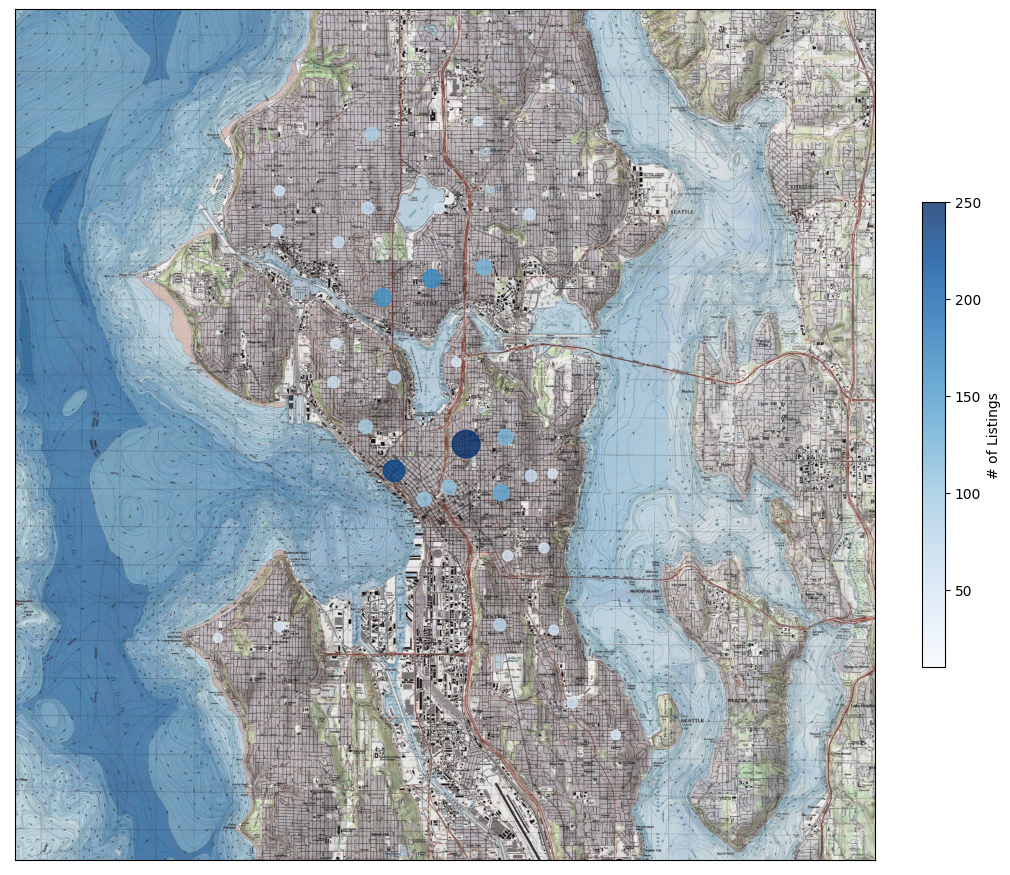

In [6]:
# Let's try to represent them on the map 
loc2_cols = ['neighbourhood_cleansed','latitude','longitude']	

long = np.median(df["longitude"])
lat = np.median(df["latitude"])

# limits latitude
maxlat= lat + 0.1
minlat= lat - 0.1


# limits longitude
maxlong= long + 0.15
minlong= long - 0.15



# creatin group for locate each different zone
dtgroup=(df
[loc2_cols]
.groupby('neighbourhood_cleansed',as_index=False)
       .agg(Lat=pd.NamedAgg(column="latitude", aggfunc=np.median),
            Long=pd.NamedAgg(column="longitude", aggfunc=np.median),
            Count=pd.NamedAgg(column="longitude", aggfunc=np.count_nonzero)))
dtgroup['Count_Pct'] = dtgroup['Count']/df.shape[0]
dtgroup = dtgroup[dtgroup['Count_Pct']>0.01].copy()

# plot
fig = plt.figure(figsize=(12, 12))
m = Basemap(projection='merc', resolution='i', 
             llcrnrlon=minlong,llcrnrlat=minlat,urcrnrlon=maxlong, urcrnrlat=maxlat, epsg = 3857, lat_0= lat, lon_0 = long
             )


m.arcgisimage(service='USA_Topo_Maps', xpixels=2000, ypixels=2000, verbose= True)

m.scatter(dtgroup["Long"].values,dtgroup["Lat"].values , latlon=True,
          c=dtgroup["Count"].values, s=dtgroup["Count"].values,
          cmap='Blues', alpha=0.8)

plt.colorbar(label="# of Listings",fraction=0.025)
plt.clim(10, 250)          



<h3 id='Part1.3'> Price  </h3>

Looking into how the property are priced based on the listing price per night, week , month and the price per guest.

In [8]:
# pricing column selections
pricing_pol = ['price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'guests_included',
       'extra_people', 'minimum_nights', 'maximum_nights','accommodates']
df_princing = df[pricing_pol].copy()

money_cols = ['price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people']

#pricing stats
df_princing[money_cols]=df_princing[money_cols].apply(dollar_to_float, axis=1)
df_princing['price_1_guest'] = df_princing['price']/df_princing['accommodates']
df_princing['weekly_price_DD'] = df_princing['price']*7
df_princing['monthly_price_DD'] = df_princing['price']*30
df_princing['weekly_discount'] = df_princing['weekly_price']/df_princing['weekly_price_DD']-1
df_princing['monthly_discount'] = df_princing['monthly_price']/df_princing['monthly_price_DD']-1

#discount for longer stays
m_discount = np.median(df_princing['monthly_discount'].values)
w_discount = np.median(df_princing['weekly_discount'].values)
# print of the results
df_princing.describe()




,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,accommodates,price_1_guest,weekly_price_DD,monthly_price_DD,weekly_discount,monthly_discount
count,3818.000000,2009.000000,1517.000000,1866.000000,2788.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,2009.000000,1517.000000
mean,127.976166,788.481832,2613.336190,287.610397,61.710904,1.672603,10.667627,2.369303,780.447617,3.349398,41.266923,895.833159,3839.284966,-0.069487,-0.259978
std,90.250022,532.352269,1722.267981,270.222690,48.830341,1.311040,17.585922,16.305902,1683.589007,1.977599,20.676221,631.750155,2707.500665,0.193504,0.216174
min,20.000000,100.000000,500.000000,95.000000,5.000000,0.000000,0.000000,1.000000,1.000000,1.000000,4.750000,140.000000,600.000000,-0.625850,-0.822222
25%,75.000000,455.000000,1512.000000,150.000000,25.000000,1.000000,0.000000,1.000000,60.000000,2.000000,27.500000,525.000000,2250.000000,-0.166667,-0.377395
50%,100.000000,650.000000,2200.000000,250.000000,50.000000,1.000000,0.000000,2.000000,1125.000000,3.000000,37.500000,700.000000,3000.000000,-0.095238,-0.285714
75%,150.000000,950.000000,3150.000000,300.000000,83.000000,2.000000,20.000000,2.000000,1125.000000,4.000000,50.000000,1050.000000,4500.000000,-0.003322,-0.166667
max,1000.000000,6300.000000,19500.000000,5000.000000,300.000000,15.000000,300.000000,1000.000000,100000.000000,16.000000,275.000000,7000.000000,30000.000000,1.428571,3.604615


c:\Users\eusep\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


http://server.arcgisonline.com/ArcGIS/rest/services/World_Street_Map/MapServer/export?bbox=-13634285.935022509,6027961.806250607,-13600890.087784523,6060994.443816173&bboxSR=3857&imageSR=3857&size=2000,2000&dpi=96&format=png32&transparent=true&f=image


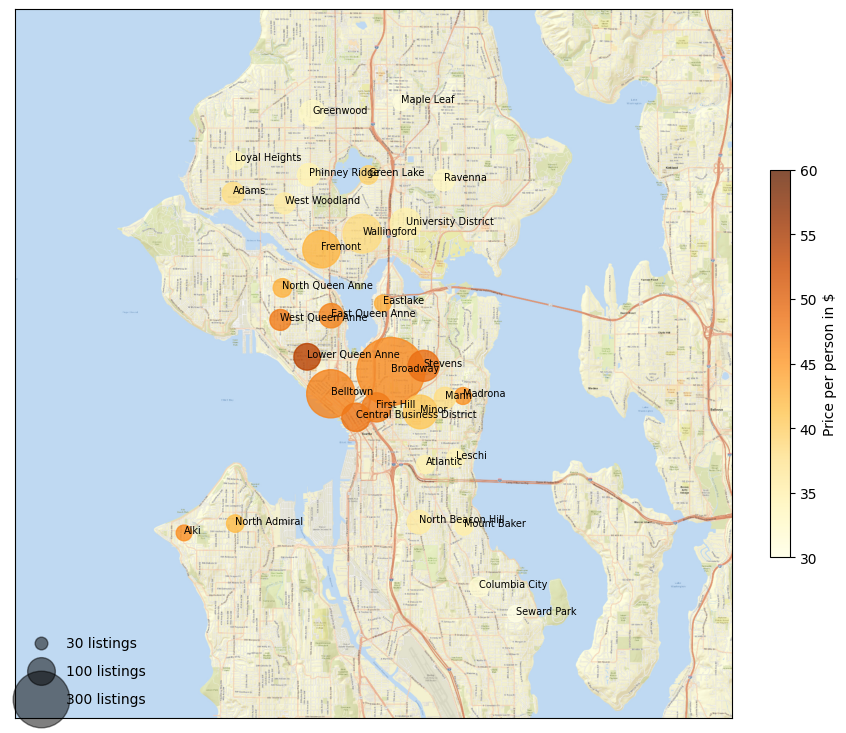

In [9]:
# Combination of pricing and location
prix_cols = ["price_1_guest"]
df_pricing_loc = pd.concat([df_princing[prix_cols],df[loc2_cols]], axis = 1)

dtgroup2=(df_pricing_loc
.groupby('neighbourhood_cleansed',as_index=False)
       .agg(Lat=pd.NamedAgg(column="latitude", aggfunc=np.median),
            Long=pd.NamedAgg(column="longitude", aggfunc=np.median),
            Count=pd.NamedAgg(column="longitude", aggfunc=np.count_nonzero),
            Price=pd.NamedAgg(column="price_1_guest", aggfunc=np.mean)))
dtgroup2['Count_Pct'] = dtgroup['Count']/df.shape[0]
dtgroup2 = dtgroup2[dtgroup2['Count_Pct']>0.01].copy()
#print(dtgroup2.sort_values('Count',ascending=False))

fig = plt.figure(figsize=(10,10))
m = Basemap(projection='merc', resolution='i',
             llcrnrlon =minlong,llcrnrlat=minlat,urcrnrlon=maxlong, urcrnrlat=maxlat, epsg = 3857  , lat_0= lat, lon_0 = long)

#test_map = Basemap(,resolution='i',projection='merc',lon_0=14.8,lat_0=47.2)
m.arcgisimage(service='World_Street_Map', xpixels=2000, ypixels=2000, verbose= True)
x,y = m(dtgroup2["Long"].values, dtgroup2["Lat"].values)
m.scatter(x, y,
          c=dtgroup2["Price"].values, s=dtgroup2["Count"].values**1.3,
          cmap='YlOrBr', alpha=0.8)

plt.colorbar(label="Price per person in $",fraction=0.025 )
plt.clim(30, 60)   

for a in [30, 100, 300]:
    plt.scatter([], [], c='k', alpha=0.5, s=a**1.3,
                label= f'{a} listings')
plt.legend(scatterpoints=1, frameon=False,
           labelspacing=1, loc='lower left');

#labels
for i in dtgroup2.index :
    if dtgroup2['Price'][i] : 
        x = dtgroup2['Long'][i]
        y = dtgroup2['Lat'][i]
        tx= dtgroup2['neighbourhood_cleansed'][i]
        xx, yy = m(x, y) #m is basemap object
        plt.text(xx,yy, tx, fontsize=7)

plt.savefig('Seattle.png',bbox_inches='tight',dpi=100)        
           

<h3 id='Part1.4'> Existing host analysis </h3>

What are the typical features of an host in Seattle? 

In [10]:
# Typical host in seattle 

Host_cols = ['host_since', 'host_location', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'calculated_host_listings_count']

desc = ((df
       [Host_cols]#.filter(df.host_location=='Seattle, Washington, United States')
              .assign(host_response_time = df.host_response_time.map({'within an hour': 1, 'within a few hours': 2, 'within a day': 3}).fillna(4),
                     host_response_rate= df.host_response_rate.str.replace(r'%', r'.0').fillna(0).astype('float') / 100.0,
                     host_acceptance_rate = df.host_acceptance_rate.str.replace(r'%', r'.0').fillna(0).astype('float')/100,
                     host_is_superhost = np.where(df.host_is_superhost =='t',1,0),
                     host_is_local = np.where(df.host_location == 'Seattle, Washington, United States', 1, 0),
                     host_how_long = (pd.to_datetime(df.last_scraped) - pd.to_datetime(df.host_since)) / np.timedelta64(1, 'D')/365)))
desc.describe()

,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,calculated_host_listings_count,host_is_local,host_how_long
count,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3818.000000,3816.000000
mean,2.007072,0.818889,0.797276,0.203772,2.946307,0.853588,2.293900
std,1.089739,0.344410,0.402081,0.402854,5.893029,0.353565,1.561083
min,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.002740
25%,1.000000,0.880000,1.000000,0.000000,1.000000,1.000000,0.972603
50%,2.000000,1.000000,1.000000,0.000000,1.000000,1.000000,2.061644
75%,3.000000,1.000000,1.000000,0.000000,2.000000,1.000000,3.383562
max,4.000000,1.000000,1.000000,1.000000,37.000000,1.000000,7.153425


In [11]:
# number of unique hosts in Seattle
(df['host_id']).nunique()

2751

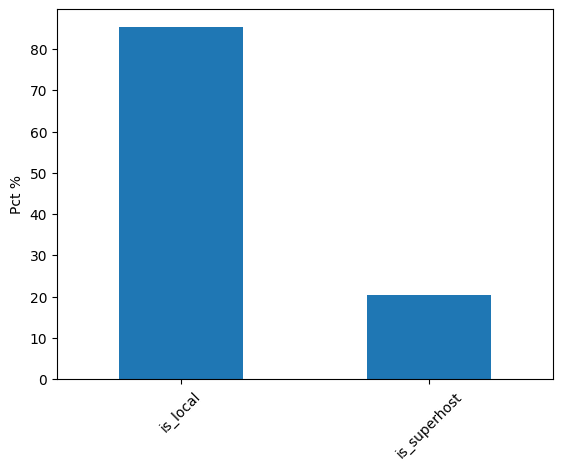

In [13]:
ppt = (100*desc[['host_is_local','host_is_superhost']]).mean().plot(kind='bar')
ppt.set_xticklabels(['is_local','is_superhost'],rotation=45)
ppt.set_ylabel("Pct %")
fig = ppt.get_figure()
fig.savefig('Host1.png',bbox_inches='tight',dpi=100) 

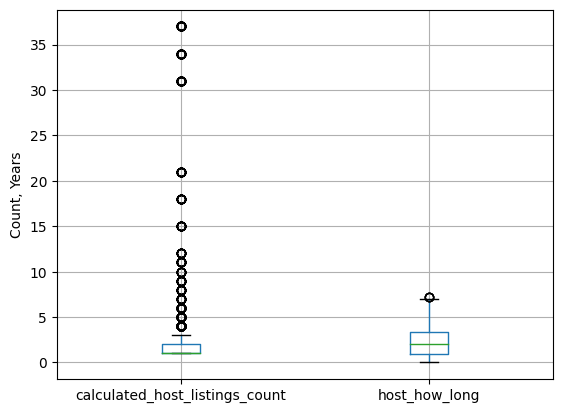

In [14]:
ppt=(desc[['calculated_host_listings_count','host_how_long']]).boxplot()
ppt.set_ylabel("Count, Years")
fig = ppt.get_figure()

fig.savefig('Host2.png',bbox_inches='tight',dpi=100) 

<AxesSubplot: >

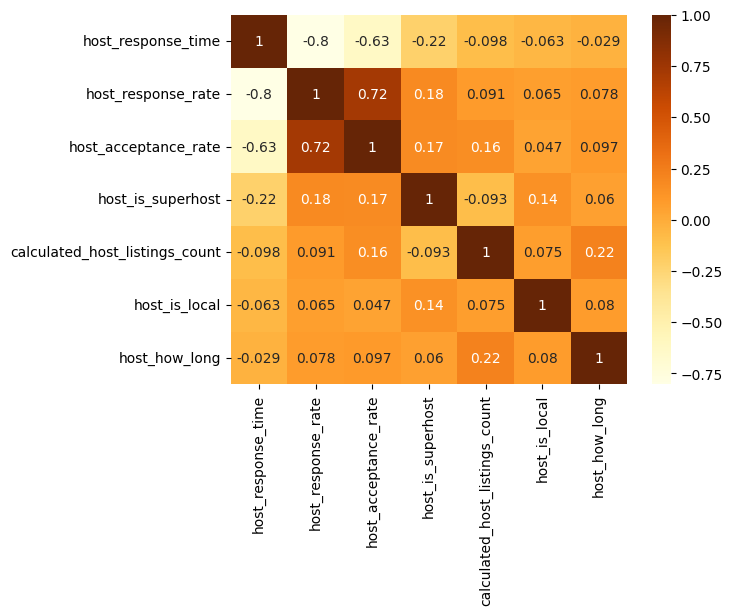

In [15]:
# analysis of corraltion 
corr = ((df
[Host_cols]#.filter(df.host_location=='Seattle, Washington, United States')
.assign(host_response_time = df.host_response_time.map({'within an hour': 1, 'within a few hours': 2, 'within a day': 3}).fillna(4),
        host_response_rate= df.host_response_rate.str.replace(r'%', r'.0').fillna(0).astype('float') / 100.0,
        host_acceptance_rate = df.host_acceptance_rate.str.replace(r'%', r'.0').fillna(0).astype('float')/100,
        host_is_superhost = np.where(df.host_is_superhost =='t',1,0),
        host_is_local = np.where(df.host_location == 'Seattle, Washington, United States', 1, 0),
        host_how_long = (pd.to_datetime(df.last_scraped) - pd.to_datetime(df.host_since)) / np.timedelta64(1, 'D')/365))).drop(['host_since','host_location'],axis =1).corr()


sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values , cmap = 'YlOrBr' , annot=True)


C:\Users\eusep\AppData\Local\Temp\ipykernel_21124\4292071689.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['host_is_superhost'] = np.where(df['host_is_superhost']=='t',True,False)
C:\Users\eusep\AppData\Local\Temp\ipykernel_21124\4292071689.py:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_new.corr()


,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,calculated_host_listings_count
count,3818.000000,3171.000000,3160.000000,3165.000000,3160.000000,3167.000000,3163.000000,3162.000000,3191.000000,3818.000000
mean,22.223415,94.539262,9.636392,9.556398,9.786709,9.809599,9.608916,9.452245,2.078919,2.946307
std,37.730892,6.606083,0.698031,0.797274,0.595499,0.568211,0.629053,0.750259,1.822348,5.893029
min,0.000000,20.000000,2.000000,3.000000,2.000000,2.000000,4.000000,2.000000,0.020000,1.000000
25%,2.000000,93.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,0.695000,1.000000
50%,9.000000,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,1.540000,1.000000
75%,26.000000,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,3.000000,2.000000
max,474.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,12.150000,37.000000


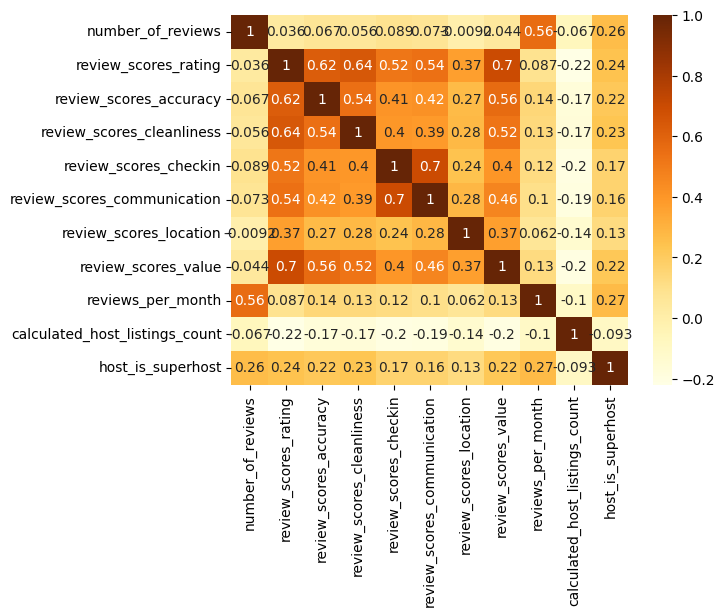

In [16]:
# remove the super host transorm the data of the super host - host repsonse rate
Review_cols = ['number_of_reviews', 'first_review', 'last_review', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 
       'review_scores_location', 'review_scores_value', 'reviews_per_month','calculated_host_listings_count','host_is_superhost','host_response_rate']     

df_new = df[Review_cols]
# get the super host - status checked
df_new['host_is_superhost'] = np.where(df['host_is_superhost']=='t',True,False)
corr = df_new.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values , cmap = 'YlOrBr' , annot=True)
df_new.describe()

<h1 id='Part2'> Data preparation </h1>

Preparing the dataset before estimating the model.

<h3 id='Part2.1'> Dependent variables </h3>

Selecting the variables we want to estimate.

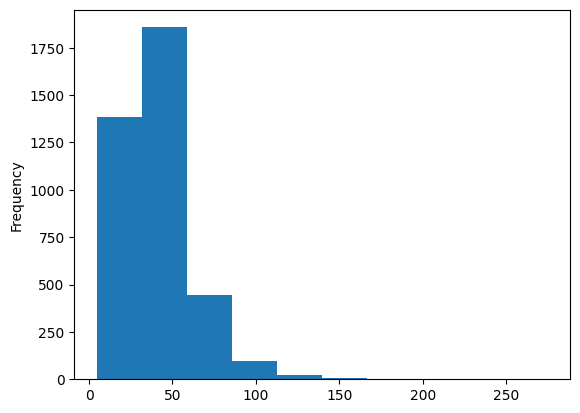

In [2]:
pricing_pol = ['price','accommodates']
df_princing = df[pricing_pol].copy()
df_princing=df_princing.apply(dollar_to_float, axis=1)
df_princing['price_1_guest'] = df_princing['price']/df_princing['accommodates']

# distribution of price per accomodate
df_princing['price_1_guest'].plot(kind='hist')

# y variable
df_princing_y = df_princing['price_1_guest'].copy()





<h3 id='Part2.2'> Indipendent variables </h3>

In [5]:
prop_columns = ["property_type","bed_type","room_type","amenities","accommodates","bathrooms","bedrooms","beds"]
loc_columns =['neighbourhood_cleansed']
review_columns = ['reviews_per_month','review_scores_rating','host_is_superhost','instant_bookable','host_response_time','last_scraped','host_since','host_location']

col_select = prop_columns + loc_columns + review_columns
#selection column
df_sel = df[col_select].copy()

# Normalise the listing features by number of accomodates
df_sel["bathrooms"] = df_sel["bathrooms"] / df_sel['accommodates']
df_sel["bedrooms"] = df_sel["bedrooms"] / df_sel['accommodates']
df_sel["beds"] = df_sel["beds"] / df_sel['accommodates']
# property type mapping
df_sel['property_type'] = df_sel['property_type'].map(
        {'House': 'House', 
         'Apartment': 'Apartment'}
    ).fillna('Other')

# Does super host help with pricing? 
df_sel['host_is_superhost'] = np.where(df_sel['host_is_superhost']=='t',True,False)
df_sel['host_is_local'] = np.where(df_sel['host_location'] == 'Seattle, Washington, United States', True,False)
# Are rating and # of review influencing pricing?
df_sel['cx_score'] = df_sel['review_scores_rating'].astype(float)/100 * df_sel['reviews_per_month'].astype(float)



# Is host booking support relevant?
df_sel = dtprep.convert_host_response_time(df_sel)
df_sel = dtprep.convert_instant_bookable(df_sel)
df_sel = dtprep.convert_host_since(df_sel)


# convert the amenities to boolean 
df_sel= dtprep.convert_amenities(df_sel)
df_sel.replace({False: 0, True: 1}, inplace=True)


# column to drop
todrop= ["accommodates","reviews_per_month","review_scores_rating",'host_since','host_location']

# taking care of NAs
df_sel = dtprep.clean_data_basic(df_sel,todrop)

# drop some cols 
df_sel = df_sel.drop(['room_type_Private room', 'room_type_Shared room'],axis = 1)
df_sel

c:\Users\eusep\OneDrive\Documenti\GitHub\AirBnB_Project\DataPrepFunctions.py:368: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['amenities_dogs'] = df['amenities'].str.contains('Dog(s)')
c:\Users\eusep\OneDrive\Documenti\GitHub\AirBnB_Project\DataPrepFunctions.py:370: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['amenities_cats'] = df['amenities'].str.contains('Cat(s)')
c:\Users\eusep\OneDrive\Documenti\GitHub\AirBnB_Project\DataPrepFunctions.py:380: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df['amenities_other_pets'] = df['amenities'].str.contains('Other pet(s)')


,bathrooms,bedrooms,beds,host_is_superhost,instant_bookable,host_response_time,host_is_local,cx_score,days_as_host,amenities_tv,...,neighbourhood_cleansed_Victory Heights,neighbourhood_cleansed_View Ridge,neighbourhood_cleansed_Wallingford,neighbourhood_cleansed_Wedgwood,neighbourhood_cleansed_West Queen Anne,neighbourhood_cleansed_West Woodland,neighbourhood_cleansed_Westlake,neighbourhood_cleansed_Whittier Heights,neighbourhood_cleansed_Windermere,neighbourhood_cleansed_Yesler Terrace
0,0.250000,0.250000,0.250000,0,0.0,2.0,1,3.8665,4.402740,1,...,0,0,0,0,1,0,0,0,0,0
1,0.250000,0.250000,0.250000,1,0.0,1.0,1,1.4208,2.868493,1,...,0,0,0,0,1,0,0,0,0,0
2,0.409091,0.454545,0.636364,0,0.0,2.0,1,1.1155,1.564384,1,...,0,0,0,0,1,0,0,0,0,0
3,0.333333,0.000000,0.666667,0,0.0,4.0,1,1.4784,2.161644,0,...,0,0,0,0,1,0,0,0,0,0
4,0.333333,0.500000,0.500000,0,0.0,1.0,1,0.8188,4.101370,1,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3813,0.333333,0.500000,0.500000,0,0.0,2.0,0,0.2400,0.728767,1,...,0,0,0,0,0,0,0,0,0,0
3814,0.250000,0.250000,0.500000,0,0.0,1.0,1,2.0000,0.224658,1,...,0,0,0,0,0,0,0,0,0,0
3815,0.500000,0.500000,0.500000,0,0.0,4.0,0,1.4784,0.013699,1,...,0,0,0,0,0,0,0,0,0,0
3816,0.500000,0.000000,0.500000,0,0.0,1.0,0,1.4784,1.002740,1,...,0,0,0,0,0,0,0,0,0,0


In [28]:
df_sel.filter(regex='property').describe()

,amenities_pets_live_on_this_property,property_type_Apartment,property_type_House,property_type_Other
count,3818.000000,3818.000000,3818.000000,3818.000000
mean,0.231273,0.447355,0.453903,0.098743
std,0.421702,0.497286,0.497936,0.298355
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,1.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000


<h1 id='Part3'> Model Estimation </h1>

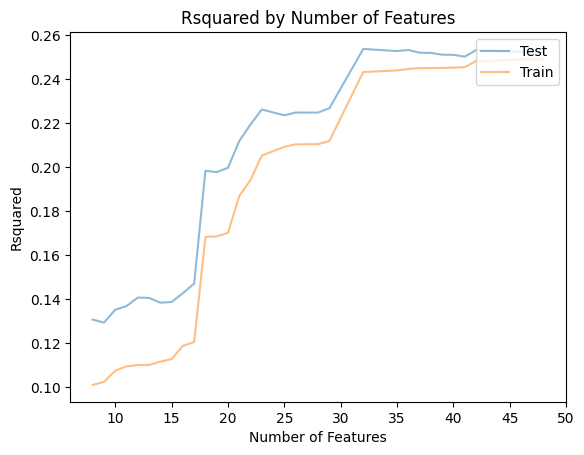

In [32]:
cutoffs = range(5,96,1)

X = df_sel
y = df_princing_y
r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test, dynam = dtprep.find_optimal_lm_mod(X, y, cutoffs, test_size = .25, norm = True, random_state = 200)


In [33]:
#extract coefficients
coef_df = dtprep.coef_weights(lm_model=lm_model,X_train= X_train)
chart = coef_df[['est_int','coefs','abs_coefs']].style.bar(subset=['coefs'], align='mid', color=['#d65f5f', '#5fba7d']) 
chart
   

,est_int,coefs,abs_coefs
31,room_type_Entire home/apt,5.067100,5.067100
1,bedrooms,4.263712,4.263712
0,bathrooms,4.100413,4.100413
12,amenities_elevator_in_building,3.188901,3.188901
4,host_response_time,3.187168,3.187168
29,property_type_House,-3.182980,3.182980
3,host_is_superhost,2.455094,2.455094
28,property_type_Apartment,-2.374407,2.374407
21,amenities_family_kid_friendly,-1.802853,1.802853
14,amenities_free_parking_on_premises,-1.708645,1.708645


In [9]:
lm_model.named_steps['clf'].coef_

KeyError: 'clf'

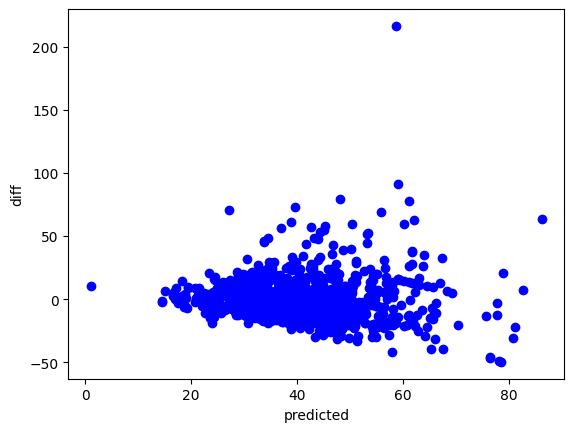

In [34]:
y_test_preds = lm_model.predict(X_test)

preds_vs_act = pd.DataFrame(np.hstack([y_test.values.reshape(y_test.size,1), y_test_preds.reshape(y_test.size,1)]))
preds_vs_act.columns = ['actual', 'preds']
preds_vs_act['diff'] = preds_vs_act['actual'] - preds_vs_act['preds']

plt.plot(preds_vs_act['preds'], preds_vs_act['diff'], 'bo');
plt.xlabel('predicted');
plt.ylabel('diff');
